In [2]:
import pandas as pd
import numpy as np
import spacy
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import fasttext.util
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Pipeline für Textklassifikation mit fastText und dem Bag-of-Words

## Datenvorbereitung

In [19]:
# load data
sample = pd.read_csv("data/labeled_unprocessed_sample_data.csv", sep=";")

In [20]:
# remove possible missing values and duplicates
sample = sample.dropna()
sample = sample.drop_duplicates(subset="answer")

In [21]:
nlp = spacy.load("de_core_news_sm")

def text_lemmatization(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct]
    return " ".join(lemmas)

In [22]:
def text_preprocessing(text):
    # remove links, punctuation, special letters
    text = re.sub(r"[^a-zA-öZÖäÄüÜß]|\bhttps?://\S*|&\w+;|[\.,]", " ", text)
    
    # replace single characters
    text : re.sub(r" [a-zA-Z] ", " ", text)
    
    # remove additional whitespaces
    text : re.sub(r"\s+", " ", text)
    
    # lemmatize texts
    text = text_lemmatization(text)

    # lower text
    text = text.lower()
    
    # tokenization of words
    text = text.split()
    
    # remove stopwords
    german_stopwords = set(stopwords.words("german"))
    text = [w for w in text if w not in german_stopwords]
    
    # return joined text
    return " ".join(text)

In [23]:
sample["clean_answer"] = sample["answer"].apply(text_preprocessing)

In [24]:
# show most frequent words
vectorizer = CountVectorizer(
)
dtm = vectorizer.fit_transform(sample["clean_answer"])

frequencies = dtm.sum(axis=0).tolist()[0]

df_freq = pd.DataFrame(
    dict(frequencies=frequencies,
         index=vectorizer.get_feature_names_out()
    )
)

df_freq.sort_values("frequencies", ascending=False).head(n=20)

,frequencies,index
9115,2010,geehrt
24694,1722,vieler
8663,1721,freundlich
11266,1698,herr
8493,1578,frage
4925,1279,dank
20683,971,sollen
15517,942,mensch
9033,901,geben
12532,895,jahr


In [25]:
# remove stopwords with refined list and after lemmatization to catch 
def remove_individual_stopwords(text):
    individual_stopwords = [
        "geehrt",
        "frau",
        "vieler",
        "dank",
        "herr",
        "danke",
        "anfrage",
        "frage",
        "nachricht",
        "freundlich",
        "sollen",
        "müssen",
        "mehr",
        "grüße",
        "daher",
        "immer",
        "dafür",
        "frage"
    ]
    text = text.split()
    text = [w for w in text if w not in individual_stopwords]
    
    return " ".join(text)

In [26]:
sample["clean_answer"] = sample["clean_answer"].apply(remove_individual_stopwords)

In [27]:
# prepare data for processing by fasttext
sample["answer_encoded"] = sample["answer_encoded"].apply(lambda x: x.replace(" ", "_"))
sample["answer_encoded"] = sample["answer_encoded"].apply(lambda x: "__label__" + x)
sample["answer_encoding_combined"] = sample["answer_encoded"]+ " " + sample["clean_answer"]

In [28]:
# seperate sample data into training, test and validation sets (80/10/10)
training_sample, temp_df = train_test_split(sample, test_size=0.2, random_state=42)
testing_sample, validation_sample = train_test_split(temp_df, test_size=0.5, random_state=42)

In [29]:
# export datasets
training_sample["answer_encoding_combined"].to_csv("data/training_data.csv", index=False, header=False, sep=";")
testing_sample["answer_encoding_combined"].to_csv("data/testing_data.csv", index=False, header=False, sep=";")
validation_sample["answer_encoding_combined"].to_csv("data/validation_data.csv", index=False, header=False, sep=";")

## Modelltraining mit Word-Embeddings

### Ohne optimierte Hyperparamater

In [30]:
# train model without optimizing the hyperparameter
ft_model = fasttext.train_supervised(input="data/training_data.csv")

In [31]:
# test model
ft_model.test("data/testing_data.csv")

(228, 0.6535087719298246, 0.6535087719298246)

### Mit optimierten Hyperparametern

In [51]:
# train model with optimizing the hyperparameter
ft_model_optimized = fasttext.train_supervised(
    input="data/training_data.csv", 
    autotuneValidationFile="data/validation_data.csv",
    thread=1,
    seed=55
    )

In [52]:
# test model
ft_model_optimized.test("data/testing_data.csv")

(228, 0.6842105263157895, 0.6842105263157895)

#### Testergebnisse für Label "answer"

In [53]:
# test model for label "answer"
answer_test = ft_model_optimized.test_label("data/testing_data.csv")["__label__answer"]

#### Testergebnisse für Label "evasive answer"

In [54]:
# test model for label "evasive answer"
evasive_answer_test = ft_model_optimized.test_label("data/testing_data.csv")["__label__evasive_answer"]

### Visualisierung von Testergebnissen für die Label

In [55]:
# create dataframe with values from testing
df_testing_results = pd.DataFrame([answer_test, evasive_answer_test])
df_testing_results.insert(0, "label", ["answer", "evasive answer"])

# change from wide to long dataframe format
heatmap_data = df_testing_results.melt(
    id_vars="label",
    value_vars=["precision", "recall"],
    var_name="Metric",
    value_name="Value"
)

[Text(0.5, 20.049999999999997, 'Metrik'),
 Text(47.24999999999999, 0.5, 'Label'),
 Text(0.5, 1.0, 'Konfusionsmatrix mit Ergebnissen der Modelltests')]

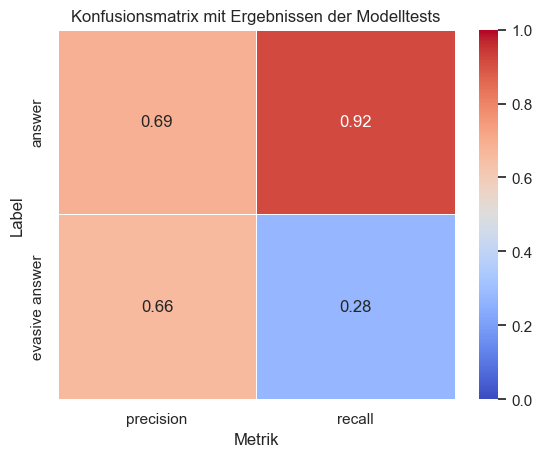

In [56]:
# create confusion matrix for model results
sns.set_theme()
ax = sns.heatmap(
   data=heatmap_data.pivot(index="label", columns="Metric", values="Value"),
   annot=True,
   linewidths=0.5,
   vmin=0,
   vmax=1,
   cmap="coolwarm"
)
ax.set(
    xlabel="Metrik",
    ylabel="Label",
    title="Konfusionsmatrix mit Ergebnissen der Modelltests"
)

In [57]:
# save trained model
ft_model_optimized.save_model("model/classification.bin")

## Modellanwendung

### Laden und Vorverarbeiten der Daten

In [58]:
# load unprocessed data without sample
data = pd.read_csv("data/data_without_sample.csv", sep=";")

In [59]:
# drop na and duplicates in answers
data = data.drop_duplicates(subset=["answer", "question_text"])
data = data.dropna(subset=["answer"])

In [60]:
# apply text cleaning
data["clean_answer"] = data["answer"].apply(text_preprocessing)
data["clean_answer"] = data["clean_answer"].apply(remove_individual_stopwords)


### Automatisches Labeln der Antworten

In [61]:
# extract answers from colums
text = data["clean_answer"].tolist()

In [62]:
# predict label and probability of label for each answer
labels, probalities = ft_model_optimized.predict(text, k=1)

### Nachbearbeiten der Labels und Probabilities für bessere Lesbarkeit

In [63]:
def flatten_list(list):
    flattened_list = []
    for item in list:
        for i in item:
            flattened_list.append(i)
    return flattened_list

flattened_labels = flatten_list(labels)
flattened_probabilities = flatten_list(probalities)

In [64]:
# append labels and probabilities to dataframe
data["label"] = flattened_labels
data["probability"] = flattened_probabilities

In [65]:
data["label"] = data["label"].apply(lambda x: x.replace("__label__", ""))

## Analyse der vergebenen Labels

### Deskriptive Auswertung Wahrscheinlichkeit der Labels korrekt zugeordnet zu werden

In [3]:
data = pd.read_csv("data/labeled_data_without_sample.csv")

In [4]:
# mean, median and std of the labels probability to be correct
df_labels = data.groupby("label")
df_labels.agg({"probability" : ["mean", "median", "std"]})

probability                    
                      mean    median       std
label                                         
answer            0.685162  0.690947  0.076912
evasive_answer    0.710257  0.669795  0.159697

In [5]:
# summarize topics to a smaller number
topics_mapped = {
    "Baden-Württemberg 2006 - 2011": "Wahlen",
    "Baden-Württemberg 2011 - 2016": "Wahlen",
    "Baden-Württemberg 2016 - 2021": "Wahlen",
    "Baden-Württemberg Wahl 2006": "Wahlen",
    "Baden-Württemberg Wahl 2011": "Wahlen",
    "Baden-Württemberg Wahl 2016": "Wahlen",
    "Baden-Württemberg Wahl 2021": "Wahlen",
    "Baden-Württemberg": "Wahlen",
    
    "Bayern": "Wahlen",
    "Bayern 2008 - 2013": "Wahlen",
    "Bayern 2013 - 2018": "Wahlen",
    "Bayern 2018 - 2023": "Wahlen",
    "Bayern Wahl 2008": "Wahlen",
    "Bayern Wahl 2013": "Wahlen",
    "Bayern Wahl 2018": "Wahlen",
    "Bayern Wahl 2023": "Wahlen",
    
    "Berlin": "Wahlen",
    "Berlin 2011 - 2016": "Wahlen",
    "Berlin 2016 - 2021": "Wahlen",
    "Berlin Wahl 2006": "Wahlen",
    "Berlin Wahl 2011": "Wahlen",
    "Berlin Wahl 2016": "Wahlen",
    "Berlin Wahl 2021": "Wahlen",
    "Berlin Wahl 2023": "Wahlen",
    
    "Brandenburg": "Wahlen",
    "Brandenburg 2014 - 2019": "Wahlen",
    "Brandenburg Wahl 2009": "Wahlen",
    "Brandenburg Wahl 2014": "Wahlen",
    "Brandenburg Wahl 2019": "Wahlen",
    
    "Bremen": "Wahlen",
    "Bremen 2015 - 2019": "Wahlen",
    "Bremen 2019 - 2023": "Wahlen",
    "Bremen Wahl 2007": "Wahlen",
    "Bremen Wahl 2011": "Wahlen",
    "Bremen Wahl 2015": "Wahlen",
    "Bremen Wahl 2019": "Wahlen",
    "Bremen Wahl 2023": "Wahlen",
    
    "Bundestag": "Wahlen",
    "Bundestag 2005 - 2009": "Wahlen",
    "Bundestag 2009 - 2013": "Wahlen",
    "Bundestag 2013 - 2017": "Wahlen",
    "Bundestag 2017 - 2021": "Wahlen",
    "Bundestag Wahl 2005": "Wahlen",
    "Bundestag Wahl 2009": "Wahlen",
    "Bundestag Wahl 2013": "Wahlen",
    "Bundestag Wahl 2017": "Wahlen",
    "Bundestag Wahl 2021": "Wahlen",
    
    "EU-Parlament": "Wahlen",
    "EU-Parlament 2004 - 2009": "Wahlen",
    "EU-Parlament 2009 - 2014": "Wahlen",
    "EU-Parlament 2014 - 2019": "Wahlen",
    "EU-Parlament 2019 - 2024": "Wahlen",
    "EU-Parlament Wahl 2004": "Wahlen",
    "EU-Parlament Wahl 2009": "Wahlen",
    "EU-Parlament Wahl 2014": "Wahlen",
    "EU-Parlament Wahl 2019": "Wahlen",
    "EU-Parlament Wahl 2024": "Wahlen",
    
    "Hamburg": "Wahlen",
    "Hamburg 2004 - 2008": "Wahlen",
    "Hamburg 2008 - 2011": "Wahlen",
    "Hamburg 2011 - 2015": "Wahlen",
    "Hamburg 2015 - 2020": "Wahlen",
    "Hamburg Wahl 2004": "Wahlen",
    "Hamburg Wahl 2008": "Wahlen",
    "Hamburg Wahl 2011": "Wahlen",
    "Hamburg Wahl 2015": "Wahlen",
    "Hamburg Wahl 2020": "Wahlen",
    
    "Hessen": "Wahlen",
    "Hessen 2018 - 2024": "Wahlen",
    "Hessen Wahl 2018": "Wahlen",
    "Hessen Wahl 2023": "Wahlen",
    
    "Mecklenburg-Vorpommern": "Wahlen",
    "Mecklenburg-Vorpommern 2016 - 2021": "Wahlen",
    "Mecklenburg-Vorpommern Wahl 2006": "Wahlen",
    "Mecklenburg-Vorpommern Wahl 2011": "Wahlen",
    "Mecklenburg-Vorpommern Wahl 2016": "Wahlen",
    "Mecklenburg-Vorpommern Wahl 2021": "Wahlen",
    
    "Niedersachsen": "Wahlen",
    "Niedersachsen 2008 - 2013": "Wahlen",
    "Niedersachsen 2013 - 2017": "Wahlen",
    "Niedersachsen 2017 - 2022": "Wahlen",
    "Niedersachsen Wahl 2008": "Wahlen",
    "Niedersachsen Wahl 2013": "Wahlen",
    "Niedersachsen Wahl 2017": "Wahlen",
    "Niedersachsen Wahl 2022": "Wahlen",
    
    "Nordrhein-Westfalen": "Wahlen",
    "Nordrhein-Westfalen 2010 - 2012": "Wahlen",
    "Nordrhein-Westfalen 2012 - 2017": "Wahlen",
    "Nordrhein-Westfalen 2017 - 2022": "Wahlen",
    "Nordrhein-Westfalen Wahl 2010": "Wahlen",
    "Nordrhein-Westfalen Wahl 2012": "Wahlen",
    "Nordrhein-Westfalen Wahl 2017": "Wahlen",
    "Nordrhein-Westfalen Wahl 2022": "Wahlen",
    
    "Rheinland-Pfalz": "Wahlen",
    "Rheinland-Pfalz 2011 - 2016": "Wahlen",
    "Rheinland-Pfalz 2016 - 2021": "Wahlen",
    "Rheinland-Pfalz Wahl 2006": "Wahlen",
    "Rheinland-Pfalz Wahl 2011": "Wahlen",
    "Rheinland-Pfalz Wahl 2016": "Wahlen",
    "Rheinland-Pfalz Wahl 2021": "Wahlen",
    
    "Saarland": "Wahlen",
    "Saarland 2017 - 2022": "Wahlen",
    "Saarland Wahl 2009": "Wahlen",
    "Saarland Wahl 2012": "Wahlen",
    
    "Sachsen": "Wahlen",
    "Sachsen 2009 - 2014": "Wahlen",
    "Sachsen 2014 - 2019": "Wahlen",
    "Sachsen 2019 - 2024": "Wahlen",
    "Sachsen Wahl 2009": "Wahlen",
    "Sachsen Wahl 2014": "Wahlen",
    "Sachsen Wahl 2019": "Wahlen",
    
    "Sachsen-Anhalt": "Wahlen",
    "Sachsen-Anhalt 2016 - 2021": "Wahlen",
    "Sachsen-Anhalt Wahl 2011": "Wahlen",
    "Sachsen-Anhalt Wahl 2006": "Wahlen",
    "Sachsen-Anhalt Wahl 2021": "Wahlen",
    
    "Schleswig-Holstein": "Wahlen",
    "Schleswig-Holstein 2009 - 2012": "Wahlen",
    "Schleswig-Holstein 2012 - 2017": "Wahlen",
    "Schleswig-Holstein 2017 - 2022": "Wahlen",
    "Schleswig-Holstein Wahl 2009": "Wahlen",
    "Schleswig-Holstein Wahl 2012": "Wahlen",
    "Schleswig-Holstein Wahl 2017": "Wahlen",
    "Schleswig-Holstein Wahl 2022": "Wahlen",
    
    "Thüringen": "Wahlen",
    "Thüringen 2014 - 2019": "Wahlen",
    "Thüringen 2019 - 2024": "Wahlen",
    "Thüringen Wahl 2009": "Wahlen",
    "Thüringen Wahl 2014": "Wahlen",
    "Thüringen Wahl 2019": "Wahlen",
    
    "Außenpolitik und internationale Beziehungen": "Außenpolitische Themen",
    "Außenwirtschaft": "Außenpolitische Themen",
    "Entwicklungspolitik": "Außenpolitische Themen",
    "Europapolitik und Europäische Union": "Außenpolitische Themen",
    "Humanitäre Hilfe": "Außenpolitische Themen",
    
    "Deutsche Einheit / Innerdeutsche Beziehungen (bis 1990)": "Inneres und Sicherheit",
    "Innere Angelegenheiten": "Inneres und Sicherheit",
    "Innere Sicherheit": "Inneres und Sicherheit",
    "Recht": "Inneres und Sicherheit",
    "Raumordnung, Bau- und Wohnungswesen": "Inneres und Sicherheit",
    "Staat und Verwaltung": "Inneres und Sicherheit",
    "Verteidigung": "Inneres und Sicherheit",
    
    "Digitale Agenda": "Digitales",
    "Inneres und Sicherheit": "Digitales",
    "Technologiefolgenabschätzung": "Digitales",
    "Wissenschaft, Forschung und Technologie": "Digitales",
    "Medien": "Digitales",
    "digitale Infrastruktur": "Digitales",
    "Medien, Kommunikation und Informationstechnik": "Digitales",
    
    "Bildung und Erziehung": "Bildung und Forschung",
    "Forschung": "Bildung und Forschung",
    
    "Umwelt": "Energie und Umwelt",
    "Energie": "Energie und Umwelt",
    "Reaktorsicherheit": "Energie und Umwelt",
    "Klima": "Energie und Umwelt",
    "Naturschutz": "Energie und Umwelt",
    "Verkehr": "Energie und Umwelt",
    
    "Finanzen": "Finanzen und Wirtschaft",
    "Öffentliche Finanzen, Steuern und Abgaben": "Finanzen und Wirtschaft",
    "Haushalt": "Finanzen und Wirtschaft",
    "Wirtschaft": "Finanzen und Wirtschaft",
    
    "Immunität": "Politik und Parteien",
    "Politisches Leben, Parteien": "Politik und Parteien",
    "Lobbyismus & Transparenz": "Politik und Parteien",
    "Geschäftsordnung": "Politik und Parteien",
    "Petitionen": "Politik und Parteien",
    "Gesellschaftspolitik, soziale Gruppen": "Politik und Parteien",
    
    "Gesundheit": "Gesundheit und Ernährung",
    "Landwirtschaft und Ernährung": "Gesundheit und Ernährung",
    "Verbraucherschutz": "Gesundheit und Ernährung",
    
    "Soziale Sicherung": "Arbeit und Beschäftigung",
    "Arbeit und Beschäftigung": "Arbeit und Beschäftigung",
    
    "Sport": "Sport, Kultur und Tourismus",
    "Sport, Freizeit und Tourismus": "Sport, Kultur und Tourismus",
    "Kultur": "Sport, Kultur und Tourismus",
    "Tourismus": "Sport, Kultur und Tourismus",
    
    "Wahlen": "Wahlen",
    "Wahlprüfung": "Wahlen",
    
    "Familie": "Frauen, Jugend, Familie",
    "Frauen": "Frauen, Jugend, Familie",
    "Senioren": "Frauen, Jugend, Familie",
    "Jugend": "Frauen, Jugend, Familie",
    
    "Migration und Aufenthaltsrecht": "Migration und Aufenthaltsrecht",
    "Menschenrechte": "Migration und Aufenthaltsrecht"
}

data["mapped_topic"] = data["topic"].map(topics_mapped)

In [6]:
data.to_csv("data/labeled_data_without_sample.csv")

In [7]:
# mean, median and std of the labels probability to be correct in regard to the topic of the question
df_labels_topics = data.groupby(["label", "mapped_topic"])
df_probality_topics_aggr = df_labels_topics.agg({"probability" : ["mean", "median", "std"]})
df_probality_topics_aggr

probability                    
                                                     mean    median       std
label          mapped_topic                                                  
answer         Arbeit und Beschäftigung          0.703628  0.713119  0.074350
               Außenpolitische Themen            0.680736  0.686298  0.073879
               Bildung und Forschung             0.675748  0.684918  0.070944
               Digitales                         0.668811  0.674031  0.072986
               Energie und Umwelt                0.663974  0.667921  0.071448
               Finanzen und Wirtschaft           0.695202  0.703157  0.075573
               Frauen, Jugend, Familie           0.699742  0.707918  0.076105
               Gesundheit und Ernährung          0.671008  0.677250  0.072264
               Inneres und Sicherheit            0.681815  0.688144  0.076923
               Migration und Aufenthaltsrecht    0.715074  0.721375  0.085733
               Politik und Parteien              0.690547  0.697493  0.078172
               Sport, Kultur und Tourismus       0.661874  0.670701  0.076515
               Wahlen                            0.703008  0.708717  0.077354
evasive_answer Arbeit und Beschäftigung          0.730075  0.705105  0.165928
               Außenpolitische Themen            0.695865  0.650571  0.159090
               Bildung und Forschung             0.677285  0.655154  0.137015
               Digitales                         0.685252  0.648053  0.147721
               Energie und Umwelt                0.696678  0.649299  0.156064
               Finanzen und Wirtschaft           0.719356  0.690214  0.161369
               Frauen, Jugend, Familie           0.711767  0.670291  0.161046
               Gesundheit und Ernährung          0.724994  0.690449  0.166472
               Inneres und Sicherheit            0.699045  0.653954  0.156688
               Migration und Aufenthaltsrecht    0.712298  0.664354  0.164791
               Politik und Parteien              0.719746  0.692353  0.157721
               Sport, Kultur und Tourismus       0.696682  0.694443  0.144295
               Wahlen                            0.714481  0.675433  0.154303

### Visualisierung der Verteilung der Labels und Topics

Text(0.5, 1.0, "Häufigkeit der Labels 'answer' und 'evasive answer'")

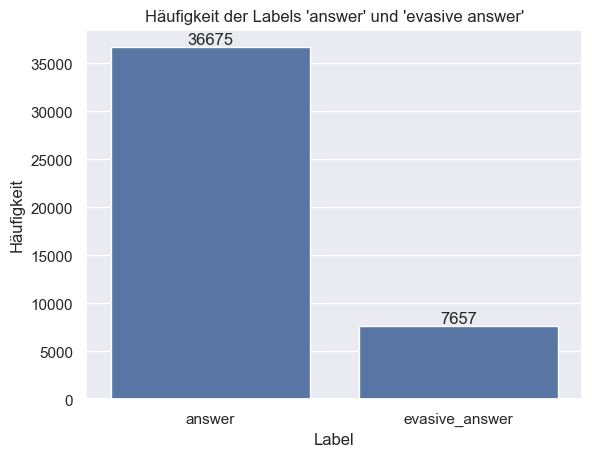

In [8]:
# create plot
sns.set_theme()
ax = sns.countplot(
    data=data,
    x="label"
)

# add value-label over bar
for i in ax.containers:
    ax.bar_label(i)

# add text to axis
plt.xlabel("Label")
plt.ylabel("Häufigkeit")
plt.title("Häufigkeit der Labels 'answer' und 'evasive answer'")


(0.0, 1.0)

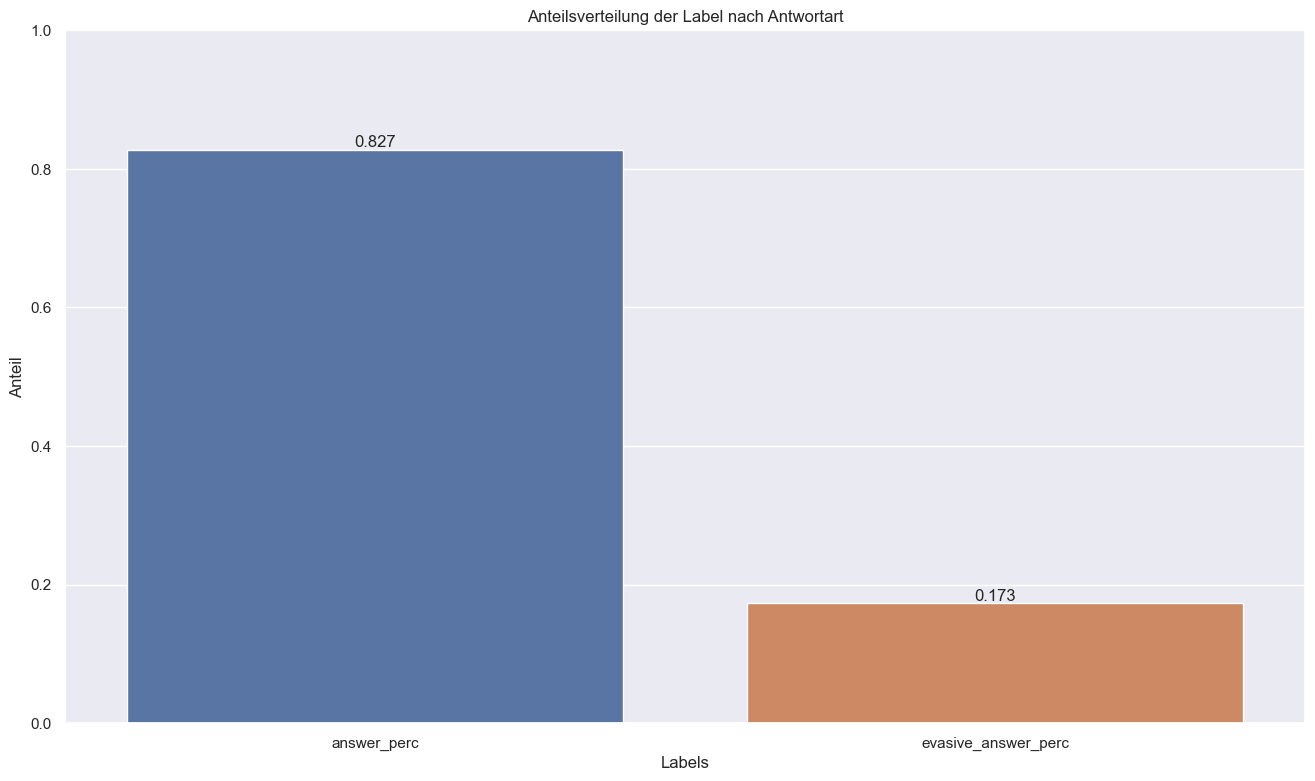

In [9]:
df_data_perc = pd.DataFrame({"total" : [data["answer"].count()]})
df_data_perc["answer"] = len(data[data["label"] == "answer"])
df_data_perc["evasive_answer"] = len(data[data["label"] == "evasive_answer"])
df_data_perc["total_perc"] = 1
df_data_perc["answer_perc"] = df_data_perc["answer"]/df_data_perc["total"]
df_data_perc["evasive_answer_perc"] = df_data_perc["evasive_answer"]/df_data_perc["total"]


sns.set_theme()
plt.figure(figsize=(16,9))
ax = sns.barplot(
    data=df_data_perc[["answer_perc", "evasive_answer_perc"]].round(decimals=3)
)

for i in ax.containers:
    ax.bar_label(i)

plt.xlabel("Labels")
plt.ylabel("Anteil")
plt.title("Anteilsverteilung der Label nach Antwortart")

plt.ylim(0,1)

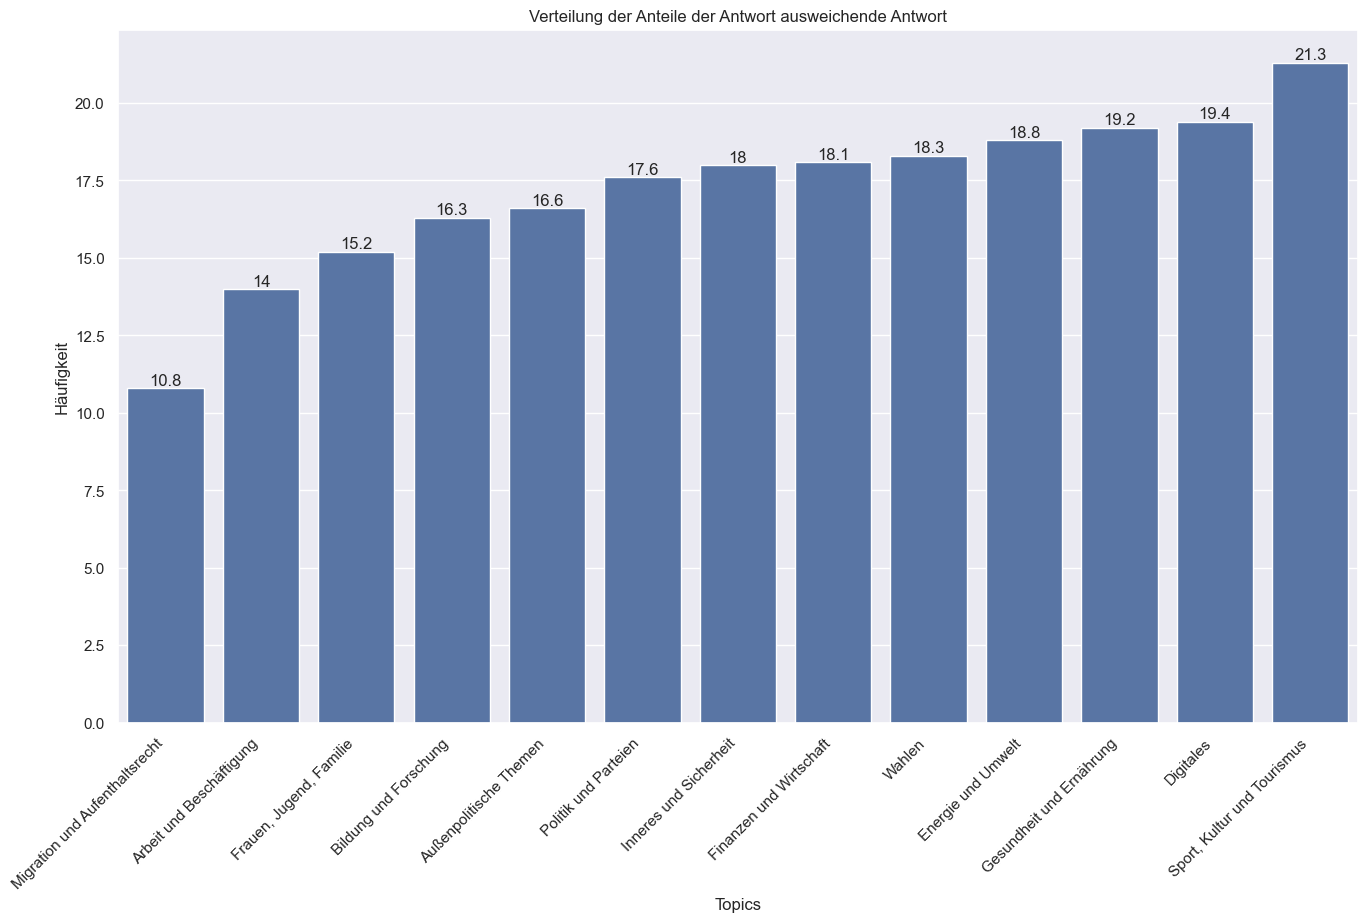

In [72]:
contingency_table = pd.crosstab(data["mapped_topic"], data["label"], normalize="index")

contingency_table_long = contingency_table.reset_index().melt(id_vars="mapped_topic", var_name="label", value_name="proportion")

contingency_table_long_filtered = contingency_table_long[contingency_table_long["label"] == "evasive_answer"]

contingency_table_long_filtered = contingency_table_long_filtered.sort_values(by=["proportion"])

contingency_table_long_filtered["proportion"] = contingency_table_long_filtered["proportion"]*100

contingency_table_long_filtered["proportion"] = contingency_table_long_filtered["proportion"].round(decimals=1)

sns.set_theme()
plt.figure(figsize=(16, 9))
ax = sns.barplot(
    data=contingency_table_long_filtered,
    x="mapped_topic",
    #order=contingency_table_long_filtered.sort_values(by=["proportion"]),
    y="proportion",
)

# add value-label over bar
for i in ax.containers:
    ax.bar_label(i)

# add text to axis
plt.xlabel("Topics")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Anteile der Antwort ausweichende Antwort")

# style plot
plt.xticks(rotation=45, ha="right")

plt.show()

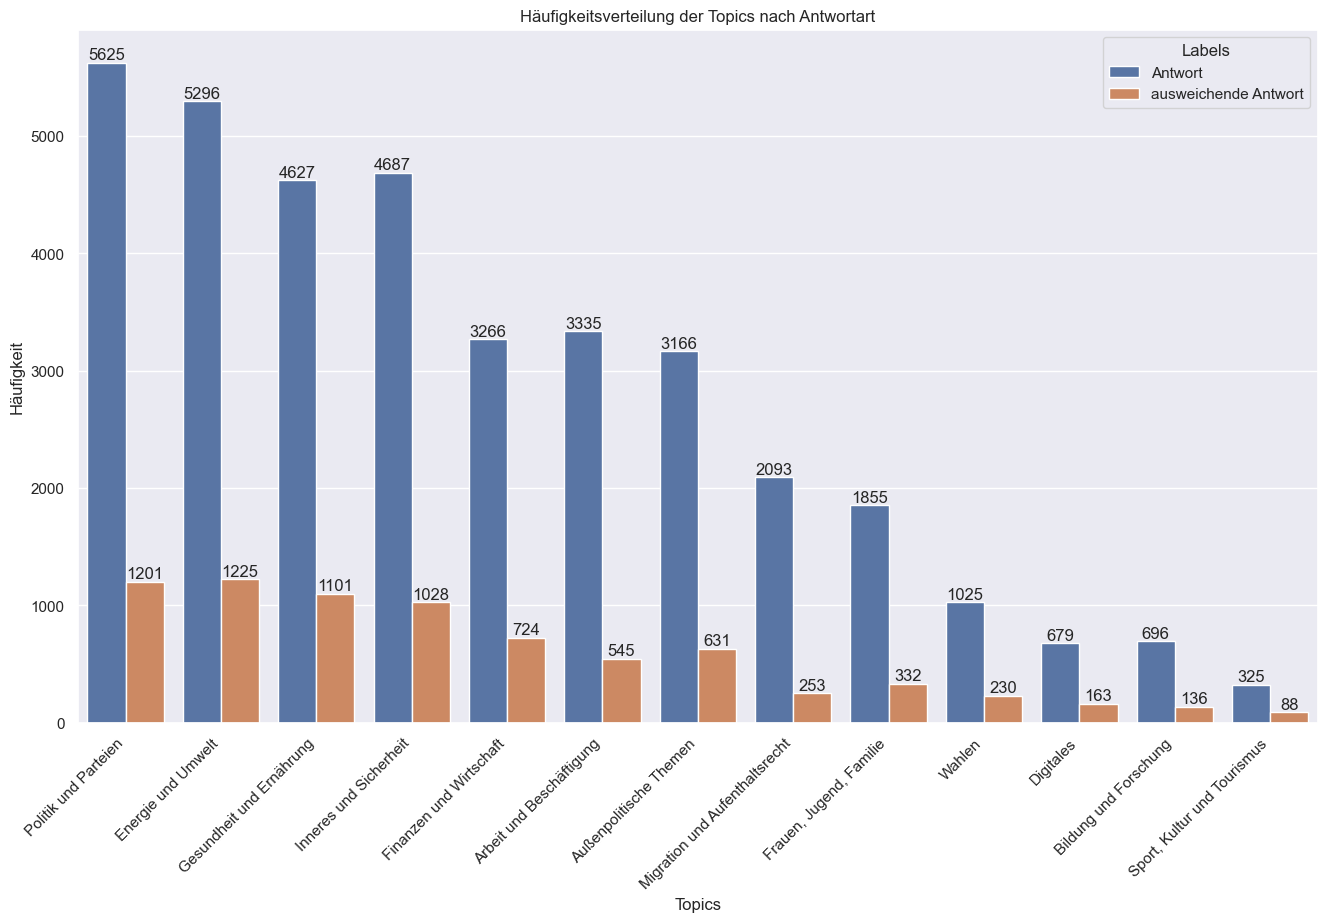

In [ ]:
# create plot 
sns.set_theme()
plt.figure(figsize=(16, 9))
ax = sns.countplot(
    data=data,
    x="mapped_topic",
    order=data["mapped_topic"].value_counts().index,
    hue="label"
)

# style legend
ax.legend(
    labels=["Antwort", "ausweichende Antwort"],
    title="Labels"
)

# add value-label over bar
for i in ax.containers:
    ax.bar_label(i)

# add text to axis
plt.xlabel("Topics")
plt.ylabel("Häufigkeit")
plt.title("Häufigkeitsverteilung der Topics nach Antwortart")

# style plot
plt.xticks(rotation=45, ha="right")

plt.show()


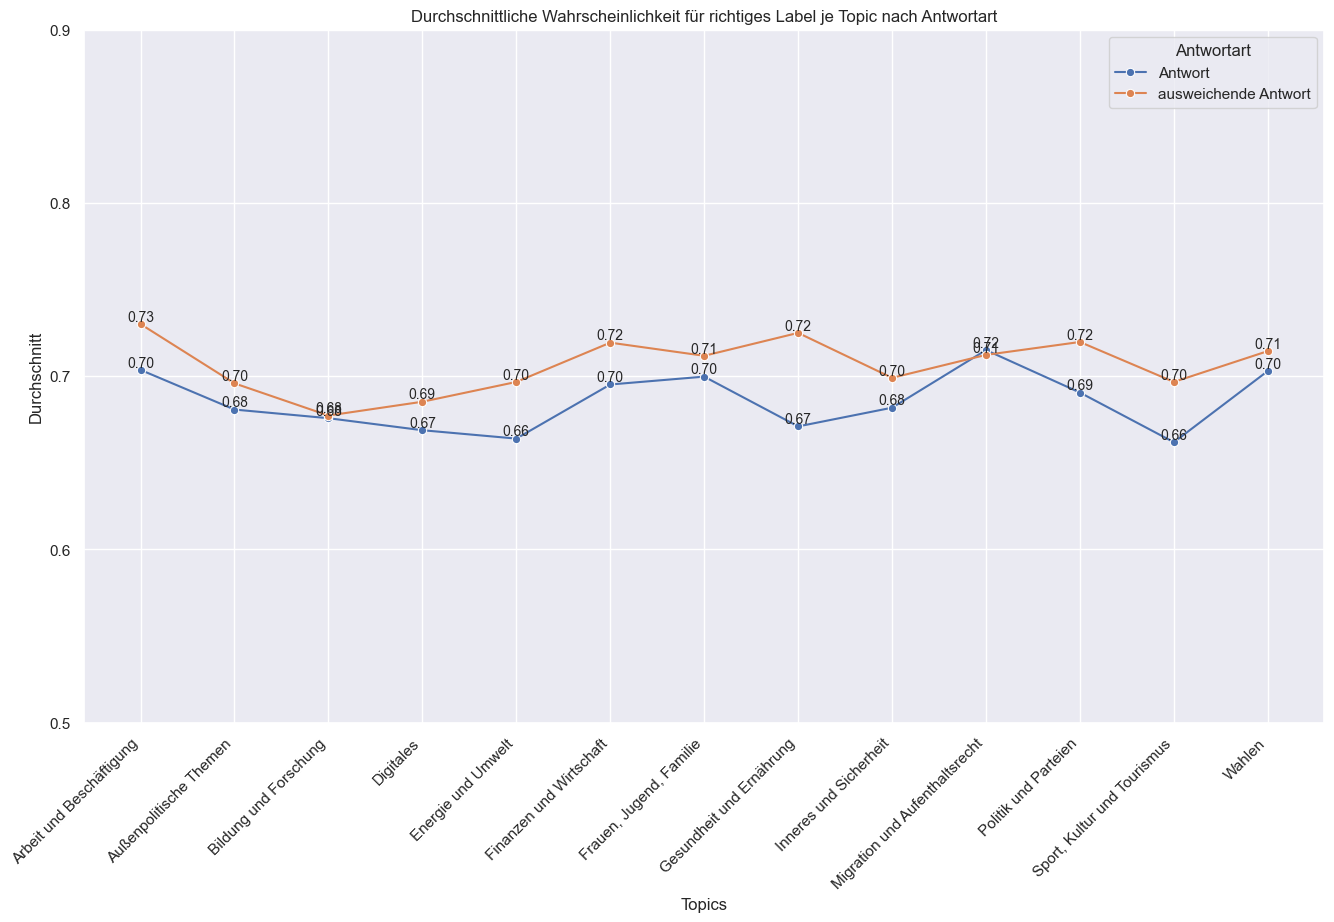

In [11]:
# create lineplot for probability
sns.set_theme()
plt.figure(figsize=(16, 9))
ax = sns.lineplot(
    x=df_probality_topics_aggr.index.get_level_values("mapped_topic"),
    y=df_probality_topics_aggr[("probability", "mean")],
    hue=df_probality_topics_aggr.index.get_level_values("label"),
    marker="o"
)

# annotate each data point with a value
# iterate over each line the in lines of the plot
for line in ax.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    # iterate over zipped lists and adjust positioning and styling
    for x, y in zip(x_data, y_data):
        ax.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=10)

# get handles to not overwrite the labels in legend
handles, _ = ax.get_legend_handles_labels()
# adjust legend
ax.legend(
    title="Antwortart",
    handles=handles,
    labels=["Antwort", "ausweichende Antwort"]
)

# add text to axis
plt.xlabel("Topics")
plt.ylabel("Durchschnitt")
plt.title("Durchschnittliche Wahrscheinlichkeit für richtiges Label je Topic nach Antwortart")

# style plot
plt.xticks(rotation=45, ha="right")
plt.yticks(ticks=np.arange(0.5, 1.0, step=0.1))

plt.show()

In [9]:
contingency_table = pd.crosstab(data["mapped_topic"], data["label"], normalize="index", )

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(contingency_table)
print("chi2: ",chi2)
print("p: ",p)
print("dof", dof)
print("expected", expected)

label                             answer  evasive_answer
mapped_topic                                            
Arbeit und Beschäftigung        0.859536        0.140464
Außenpolitische Themen          0.833816        0.166184
Bildung und Forschung           0.836538        0.163462
Digitales                       0.806413        0.193587
Energie und Umwelt              0.812145        0.187855
Finanzen und Wirtschaft         0.818546        0.181454
Frauen, Jugend, Familie         0.848194        0.151806
Gesundheit und Ernährung        0.807786        0.192214
Inneres und Sicherheit          0.820122        0.179878
Migration und Aufenthaltsrecht  0.892157        0.107843
Politik und Parteien            0.824055        0.175945
Sport, Kultur und Tourismus     0.786925        0.213075
Wahlen                          0.816733        0.183267
chi2:  0.06129172294076775
p:  0.9999999999988793
dof 12
expected [[0.82792064 0.17207936]
 [0.82792064 0.17207936]
 [0.82792064 0.17207936]
 [0.